In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATA_DIR = '../../data'
data_file = f'{DATA_DIR}/nyse_historic.csv'

In [3]:
data = pd.read_csv(data_file, 
                   usecols=['Date', 'Adj Close'], 
                   parse_dates=True, 
                   index_col='Date')
data = data.rename(columns={'Adj Close': 'Close'})
data.head()

,Close
Date,
1965-12-31,528.690002
1966-01-03,527.210022
1966-01-04,527.840027
1966-01-05,531.119995
1966-01-06,532.070007


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13365 entries, 1965-12-31 to 2019-02-05
Data columns (total 1 columns):
Close    13364 non-null float64
dtypes: float64(1)
memory usage: 208.8 KB


In [5]:
data.describe()

,Close
count,13364.000000
mean,4067.187136
std,3701.605936
min,347.769989
25%,640.742508
50%,2422.334961
75%,6939.512574
max,13637.019531


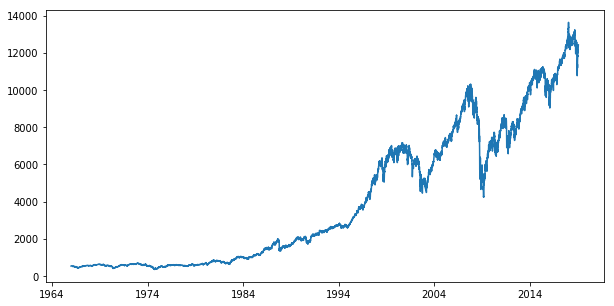

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(data);

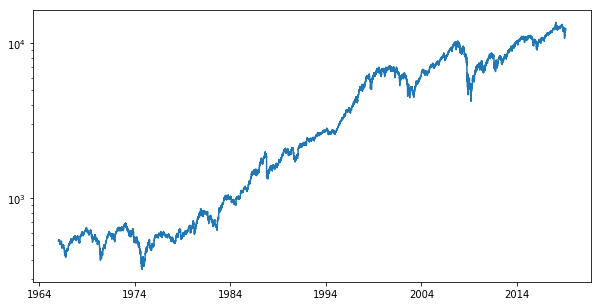

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(data)
plt.yscale('log');

In [8]:
data['PctChange'] = data.pct_change()
data.head()

,Close,PctChange
Date,,
1965-12-31,528.690002,NaN
1966-01-03,527.210022,-0.002799
1966-01-04,527.840027,0.001195
1966-01-05,531.119995,0.006214
1966-01-06,532.070007,0.001789


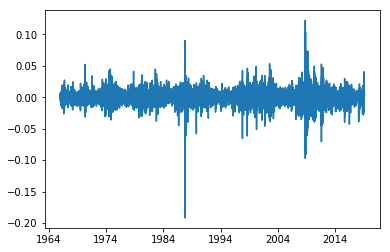

In [9]:
plt.plot(data.PctChange);

In [10]:
data['LogReturns'] = np.log(1 + data.PctChange)

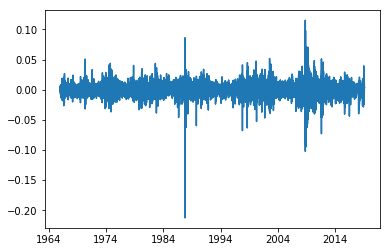

In [11]:
plt.plot(data.LogReturns);

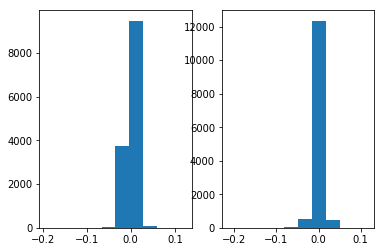

In [12]:
plt.subplot(121)
plt.hist(data.PctChange[1:])
plt.subplot(122)
plt.hist(data.LogReturns[1:]);